In [1]:
import os, os.path
import sys
import time

import shutil

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

import torch
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv

# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader

from torch.utils.data import random_split




In [4]:

sys.path.append('../../ai.rdee')
import ai_rdee

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
class TGCN_dataset(torch.utils.data.Dataset):
    def __init__(self):
        for f in self.processed_file_names:
            if not os.path.exists(f):
                self.process()
        self.data = torch.load(self.processed_file_names[0])

    @property
    def raw_file_names(self):
        return ['data/sz_adj.csv', 'data/sz_speed.csv']

    @property
    def processed_file_names(self):
        return ['data_sz_GRU.pt']

    def download(self):
        # Download to `self.raw_dir`.
        print("Please download the data manually!")
        sys.exit(0)
        
    def process(self):
        for f in self.raw_file_names:
            if not os.path.exists(f):
                slef.download()
                break
        print("Processing ... ...")
        # Read data into huge `Data` list.
        fn_adj, fn_spd = self.raw_file_names
        df_spd = pd.read_csv(fn_spd)
        S = df_spd.values  # nTimes x nNodes
        
        data = np.zeros((S.shape[0]-14, 15, S.shape[1]))
        for i in range(data.shape[0]):
            data[i,:,:] = S[i:i+15, :]
        
        torch.save(torch.Tensor(data), self.processed_file_names[0])
        print("Process done.")
        
    def clean(self):
        os.remove('data_sz_GRU.pt')
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx: int):
        return self.data[idx, :, :]

In [7]:
ds = TGCN_dataset()

In [8]:
ratio_valid = 0.2

In [9]:
size_valid = int(ratio_valid * len(ds))
size_train = len(ds) - size_valid
ds_learn, ds_valid = random_split(ds, [size_train, size_valid])

In [10]:
def collate_fn(batch):
#     global b1
#     b1 = batch
    # batch: (batchSize, seq, nFeatures)
    batchTS = torch.stack(batch)
    return batchTS[:, :12, :], batchTS[:, 12:, :].permute(0, 2, 1).contiguous()
#     return batchTS[:, :12, :].permute(0,2,1).contiguous(), batchTS[:, 12:, :].permute(0,2,1).contiguous()# .view(batchTS.shape[0], -1)

In [11]:
dlr_train = torch.utils.data.DataLoader(ds_learn, shuffle=True, batch_size=64, collate_fn=collate_fn)

In [12]:
dlr_valid = torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=size_valid, collate_fn=collate_fn)

In [13]:
a, b = next(iter(dlr_train))
print(a.shape)
print(b.shape)

torch.Size([64, 12, 156])
torch.Size([64, 156, 3])


In [16]:
net = GRU(156, 100)

In [17]:
net(a).shape

torch.Size([64, 156, 3])

In [18]:
b.shape

torch.Size([64, 156, 3])

In [19]:
net.to(device)

GRU(
  (gru_cell): GRUCell(
    (linear1): GRULinear()
    (linear2): GRULinear()
  )
  (L1): Linear(in_features=100, out_features=3, bias=True)
)

In [20]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1.5e-3)
criterion = nn.MSELoss()

esp = ai_rdee.AiTools.EarlyStopping(60)



In [14]:
xV, yV = next(iter(dlr_valid))

In [18]:
yV.mean()

tensor(11.9676)

In [22]:
lossesT = []
lossesE = []
lossesV = []

for epoch in range(3000):
    lossesE = []
    net.train()
    for x, y in dlr_train:
        optim.zero_grad()

        y_hat = net(x.to(device))
        loss = criterion(y_hat.view(-1), y.view(-1).to(device))
        if np.isnan(loss.item()):
            print("nan loss! Stop")
            break
        loss.backward()
        optim.step()
        lossesE.append(loss.item())
    lossesT.append(np.array(lossesE).mean())
    
    net.eval()
    
    with torch.no_grad():
        yV_hat = net(xV.to(device))
        lossesV.append(criterion(yV_hat.view(-1), yV.view(-1).to(device)).item())
    if epoch % 10 == 0:
        print(f"epoch={epoch}, lossT={lossesT[-1]:.3f}, lossV={lossesV[-1]:.3f}, minV={esp.val_loss_min:.3f}  |  @{time.ctime()}")
    esp(lossesV[-1], net)
    if esp.early_stop:
        print(f"Early stopping at {epoch}")
        break

    

epoch=0, lossT=25.913, lossV=26.406, minV=25.764  |  @Mon Oct  9 16:49:43 2023
epoch=10, lossT=25.938, lossV=25.883, minV=25.761  |  @Mon Oct  9 16:49:51 2023
epoch=20, lossT=25.360, lossV=25.748, minV=25.741  |  @Mon Oct  9 16:49:59 2023
epoch=30, lossT=25.359, lossV=25.830, minV=25.741  |  @Mon Oct  9 16:50:07 2023
epoch=40, lossT=25.630, lossV=25.792, minV=25.741  |  @Mon Oct  9 16:50:14 2023
epoch=50, lossT=25.380, lossV=25.921, minV=25.730  |  @Mon Oct  9 16:50:22 2023
epoch=60, lossT=25.404, lossV=25.824, minV=25.730  |  @Mon Oct  9 16:50:30 2023
epoch=70, lossT=25.170, lossV=25.734, minV=25.730  |  @Mon Oct  9 16:50:37 2023
epoch=80, lossT=25.525, lossV=25.791, minV=25.730  |  @Mon Oct  9 16:50:45 2023
epoch=90, lossT=25.987, lossV=26.131, minV=25.718  |  @Mon Oct  9 16:50:53 2023
epoch=100, lossT=25.098, lossV=25.715, minV=25.718  |  @Mon Oct  9 16:51:00 2023
epoch=110, lossT=26.209, lossV=25.753, minV=25.715  |  @Mon Oct  9 16:51:08 2023
epoch=120, lossT=24.944, lossV=25.720, 

In [23]:
rgp = ai_rdee.Regression.RegressionPerformance()
rgp.valid(yV_hat.detach().cpu().view(-1), yV.reshape(-1))
rgp.valid.show()

target : tg1
size   = 277056.000
r      =      0.915
r2     =      0.837
rmse   =      5.065
nRMSE  =      0.404
MSE    =     25.654


In [24]:
import torchmetrics

D:\XAPP\miniconda3\envs\ai\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [25]:
torchmetrics.functional.mean_squared_error(yV_hat.detach().cpu().view(-1), yV.reshape(-1))

tensor(25.6538)

In [45]:
class myGRU(nn.Module):
    def __init__(self, input_dim, GRU_dim, output_dim):
        super().__init__()
        self.GRU_dim = GRU_dim
        self.GRULayer = nn.GRU(input_dim, GRU_dim, batch_first=True)
        self.Regressor = nn.Linear(GRU_dim, output_dim)
        
    def forward(self, inputs):
        batch_size, num_nodes, seq_len = inputs.shape
#         h0 = torch.zeros(batch_size, num_nodes * self.GRU_dim).type_as(
#             inputs
#         )
#         print(inputs.shape)
        out, h_gru = self.GRULayer(inputs.view(batch_size * num_nodes, seq_len, 1))  # h_gru : (1, batchsize, hidden_dim)
#         print(h_gru.shape)
        x = self.Regressor(h_gru.squeeze(0))
        return x

In [ ]:
net = GRU()

net.to(device)

optim = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1.5e-3)
criterion = nn.MSELoss()

esp = ai_rdee.AiTools.EarlyStopping(60)

xV, yV = next(iter(dlr_valid))

In [20]:
lossesT = []
lossesE = []
lossesV = []

for epoch in range(3000):
    lossesE = []
    net.train()
    for x, y in dlr_train:
        optim.zero_grad()

        y_hat = net(x.to(device))
        loss = criterion(y_hat.view(-1), y.view(-1).to(device))
        if np.isnan(loss.item()):
            print("nan loss! Stop")
            break
        loss.backward()
        optim.step()
        lossesE.append(loss.item())
    lossesT.append(np.array(lossesE).mean())
    
    net.eval()
    
    with torch.no_grad():
        yV_hat = net(xV.to(device))
        lossesV.append(criterion(yV_hat.view(-1), yV.view(-1).to(device)).item())
    if epoch % 1 == 0:
        print(f"epoch={epoch}, lossT={lossesT[-1]:.3f}, lossV={lossesV[-1]:.3f}, minV={esp.val_loss_min:.3f}  |  @{time.ctime()}")
    esp(lossesV[-1], net)
    if esp.early_stop:
        print(f"Early stopping at {epoch}")
        break


epoch=0, lossT=184.479, lossV=97.798, minV=inf  |  @Mon Oct  9 16:07:06 2023
epoch=1, lossT=84.172, lossV=60.202, minV=97.798  |  @Mon Oct  9 16:07:07 2023
epoch=2, lossT=59.408, lossV=47.137, minV=60.202  |  @Mon Oct  9 16:07:08 2023
epoch=3, lossT=48.835, lossV=40.663, minV=47.137  |  @Mon Oct  9 16:07:09 2023
epoch=4, lossT=43.205, lossV=37.166, minV=40.663  |  @Mon Oct  9 16:07:10 2023
epoch=5, lossT=39.902, lossV=34.652, minV=37.166  |  @Mon Oct  9 16:07:10 2023
epoch=6, lossT=37.226, lossV=32.933, minV=34.652  |  @Mon Oct  9 16:07:11 2023
epoch=7, lossT=35.757, lossV=31.846, minV=32.933  |  @Mon Oct  9 16:07:12 2023
epoch=8, lossT=34.244, lossV=30.909, minV=31.846  |  @Mon Oct  9 16:07:13 2023
epoch=9, lossT=33.464, lossV=30.360, minV=30.909  |  @Mon Oct  9 16:07:14 2023
epoch=10, lossT=32.819, lossV=29.817, minV=30.360  |  @Mon Oct  9 16:07:15 2023
epoch=11, lossT=32.101, lossV=29.645, minV=29.817  |  @Mon Oct  9 16:07:16 2023
epoch=12, lossT=31.888, lossV=29.287, minV=29.645  |

epoch=103, lossT=29.742, lossV=27.928, minV=27.886  |  @Mon Oct  9 16:08:36 2023
epoch=104, lossT=29.694, lossV=27.934, minV=27.886  |  @Mon Oct  9 16:08:37 2023
epoch=105, lossT=29.795, lossV=27.941, minV=27.886  |  @Mon Oct  9 16:08:38 2023
epoch=106, lossT=29.716, lossV=27.875, minV=27.886  |  @Mon Oct  9 16:08:39 2023
epoch=107, lossT=29.890, lossV=27.891, minV=27.875  |  @Mon Oct  9 16:08:40 2023
epoch=108, lossT=29.812, lossV=27.878, minV=27.875  |  @Mon Oct  9 16:08:40 2023
epoch=109, lossT=29.886, lossV=27.920, minV=27.875  |  @Mon Oct  9 16:08:41 2023
epoch=110, lossT=29.754, lossV=27.919, minV=27.875  |  @Mon Oct  9 16:08:42 2023
epoch=111, lossT=29.669, lossV=27.884, minV=27.875  |  @Mon Oct  9 16:08:43 2023
epoch=112, lossT=29.800, lossV=27.942, minV=27.875  |  @Mon Oct  9 16:08:44 2023
epoch=113, lossT=29.821, lossV=27.926, minV=27.875  |  @Mon Oct  9 16:08:45 2023
epoch=114, lossT=29.774, lossV=27.949, minV=27.875  |  @Mon Oct  9 16:08:46 2023
epoch=115, lossT=29.773, los

epoch=205, lossT=29.554, lossV=27.896, minV=27.819  |  @Mon Oct  9 16:10:07 2023
epoch=206, lossT=29.576, lossV=27.957, minV=27.819  |  @Mon Oct  9 16:10:08 2023
epoch=207, lossT=29.498, lossV=27.872, minV=27.819  |  @Mon Oct  9 16:10:09 2023
epoch=208, lossT=29.392, lossV=27.862, minV=27.819  |  @Mon Oct  9 16:10:09 2023
epoch=209, lossT=29.416, lossV=27.833, minV=27.819  |  @Mon Oct  9 16:10:10 2023
epoch=210, lossT=29.586, lossV=27.866, minV=27.819  |  @Mon Oct  9 16:10:11 2023
epoch=211, lossT=29.399, lossV=27.905, minV=27.819  |  @Mon Oct  9 16:10:12 2023
epoch=212, lossT=29.465, lossV=27.832, minV=27.819  |  @Mon Oct  9 16:10:13 2023
epoch=213, lossT=29.390, lossV=27.864, minV=27.819  |  @Mon Oct  9 16:10:14 2023
epoch=214, lossT=29.404, lossV=27.840, minV=27.819  |  @Mon Oct  9 16:10:15 2023
epoch=215, lossT=29.353, lossV=27.852, minV=27.819  |  @Mon Oct  9 16:10:16 2023
epoch=216, lossT=29.480, lossV=27.861, minV=27.819  |  @Mon Oct  9 16:10:16 2023
epoch=217, lossT=29.378, los

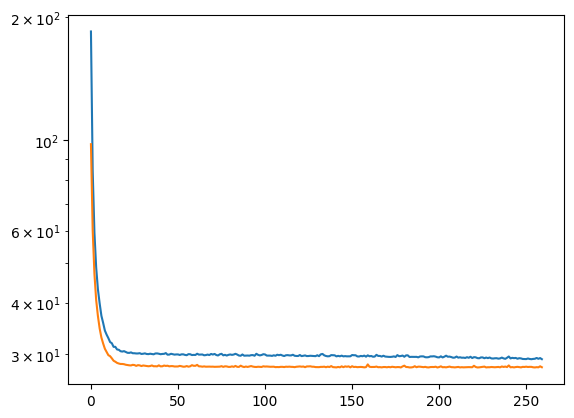

In [21]:
plt.plot(lossesT)
plt.plot(lossesV)
plt.yscale('log')

In [24]:
rgp.valid(yV_hat.detach().cpu().view(-1), yV.reshape(-1))

rgp.valid.show()